<a href="https://colab.research.google.com/github/santmukhgit/Capstone-Computer-Vision/blob/main/Capstone_Project_Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Installing and Importing Necessary Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.patches as patches
import glob # for file path handling
from PIL import Image # For image loading and manipulation
import xml.etree.ElementTree as ET # For handling XML annotations (common for object detection datasets)
import matplotlib.pyplot as plt # For visualization
from sklearn.model_selection import train_test_split # For potential data splitting if needed
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# **Load the Dataset**

In [ ]:
# Define paths
dataset_path = '/content/drive/My Drive/Colab Notebooks/Capstone_Projects/Project 2 - Car Detection' # Replace with the actual path

# for images
train_images_path = os.path.join(dataset_path, 'Car Images/Train Images')
test_images_path = os.path.join(dataset_path, 'Car Images/Test Images')

#for annotations
train_image_annot_dir_file = pd.read_csv(os.path.join(dataset_path, 'Annotations/Train Annotations.csv'))
test_image_annot_dir_file = pd.read_csv(os.path.join(dataset_path, 'Annotations/Test Annotation.csv'))


In [ ]:
#train_anno_df.rename(columns={'Bounding Box coordinates': 'Bounding Box coordinates_xmin', 'Unnamed: 2': 'Bounding Box coordinates_ymin','Unnamed: 3': 'Bounding Box coordinates_ymin','Unnamed: 4': 'Bounding Box coordinates_ymax'}, inplace=True)
train_image_annot_dir_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Image Name                     8144 non-null   object
 1   Bounding Box coordinates_xmin  8144 non-null   int64 
 2   Bounding Box coordinates_ymin  8144 non-null   int64 
 3   Bounding Box coordinates_xmax  8144 non-null   int64 
 4   Bounding Box coordinates_ymax  8144 non-null   int64 
 5   Image class                    8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [ ]:
train_image_annot_dir_file.head(5)

,Image Name,Bounding Box coordinates_xmin,Bounding Box coordinates_ymin,Bounding Box coordinates_xmax,Bounding Box coordinates_ymax,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [ ]:
#test_anno_df.rename(columns={'Bounding Box coordinates': 'Bounding Box coordinates_xmin', 'Unnamed: 2': 'Bounding Box coordinates_ymin','Unnamed: 3': 'Bounding Box coordinates_ymin','Unnamed: 4': 'Bounding Box coordinates_ymax'}, inplace=True)
test_image_annot_dir_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Image Name                     8041 non-null   object
 1   Bounding Box coordinates_xmin  8041 non-null   int64 
 2   Bounding Box coordinates_ymin  8041 non-null   int64 
 3   Bounding Box coordinates_xmax  8041 non-null   int64 
 4   Bounding Box coordinates_ymax  8041 non-null   int64 
 5   Image class                    8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.1+ KB


In [ ]:
test_image_annot_dir_file.head(5)

,Image Name,Bounding Box coordinates_xmin,Bounding Box coordinates_ymin,Bounding Box coordinates_xmax,Bounding Box coordinates_ymax,Image class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [ ]:
train_class_folders = [f.path for f in os.scandir(train_images_path) if f.is_dir()]
test_class_folders = [f.path for f in os.scandir(test_images_path) if f.is_dir()]
train_image_classes = {} # Dictionary to store training image: class mapping
test_image_classes = {}  # Dictionary to store testing image: class mapping

# Define columns for the Training DataFrame
columns_training = ['Image_Path', 'labels']

# Create an empty DataFrame
df_training = pd.DataFrame(columns=columns_training)

# --- Map filenames in a class for train_image_classes
for class_folder in train_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_train.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         train_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_training.append(image_file)
         df_training.loc[len(df_training)] = [image_file, class_name]


print(df_training.head(10))

# Define columns for the Testing DataFrame
columns_testing = ['Image_Path', 'labels']

# Create an empty DataFrame
df_testing = pd.DataFrame(columns=columns_testing)

# similar logic for test_images_path and test_image_classes
for class_folder in test_class_folders:
     class_name = os.path.basename(class_folder) # Extract class name from folder name
     #labels_testing.append(class_name)
     image_files = glob.glob(os.path.join(class_folder, '*.jpg')) # images are .jpg
     for image_file in image_files:
         test_image_classes[os.path.basename(image_file)] = class_name # Map filename to class
         #image_file_path_testing.append(image_file)
         df_testing.loc[len(df_testing)] = [image_file, class_name]

print(df_testing.head(10))


# --- Print a few mappings to verify ---
print("Sample Training Image to Class Mappings:")
count = 0
for img_name, class_label in train_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only

print("Sample Testing Image to Class Mappings:")
count = 0
for img_name, class_label in test_image_classes.items():
    print(f"{img_name}: {class_label}")
    count += 1
    if count > 5: break # Print first few only


                                          Image_Path                   labels
0  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
1  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
2  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
3  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
4  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
5  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
6  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
7  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
8  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
9  /content/drive/My Drive/Colab Notebooks/Capsto...  Toyota 4Runner SUV 2012
                                          Image_Path  \
0  /content/drive/My Drive/Colab Notebooks/Capsto...   
1  /content/drive/My Drive/Col

## **Map Training and Testing Images to Their Classes to its annotations**

Create mappings that associate each image filename with its bounding box annotations.

In [ ]:

# ********Definition of the method ********************************
def map_images_to_bboxes(annotations_file):
    """
    Maps image filenames to bounding box annotations from a CSV file.

    Args:
        annotations_file (df): Dataframe of the CSV annotation file.

    Returns:
        dict: A dictionary where keys are image filenames (without extension)
              and values are bounding box tuples (xmin, ymin, xmax, ymax).
    """
    image_bboxes = {}
    try:
        for index, row in annotations_file.iterrows():
                image_name = row['Image Name']
                x_min = row['Bounding Box coordinates_xmin']
                y_min = row['Bounding Box coordinates_ymin']
                x_max = row['Bounding Box coordinates_xmax']
                y_max = row['Bounding Box coordinates_ymax']
                image_class = row['Image class']

                image_bboxes[image_name] = (x_min, y_min, x_max, y_max) # Store bbox as tuple

    except FileNotFoundError:
        print(f"Error: Annotation file not found: {annotations_file}")
    except KeyError as e:
        print(f"Error: Column '{e}' not found in CSV file. Check your CSV column names.")
        print("Expected columns (example): filename, xmin, ymin, xmax, ymax") # Example expected columns

    return image_bboxes

train_image_bboxes = map_images_to_bboxes(train_image_annot_dir_file)
test_image_bboxes = map_images_to_bboxes(test_image_annot_dir_file)

# --- Print a few mappings to verify for Training images ---
print("\nSample Training Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in train_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break

# --- Print a few mappings to verify  testing images---
print("\nSample Testing Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in test_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break


Sample Training Image to Bounding Box Mappings (DF):
00001.jpg: (39, 116, 569, 375)
00002.jpg: (36, 116, 868, 587)
00003.jpg: (85, 109, 601, 381)
00004.jpg: (621, 393, 1484, 1096)
00005.jpg: (14, 36, 133, 99)
00006.jpg: (259, 289, 515, 416)

Sample Testing Image to Bounding Box Mappings (DF):
00001.jpg: (30, 52, 246, 147)
00002.jpg: (100, 19, 576, 203)
00003.jpg: (51, 105, 968, 659)
00004.jpg: (67, 84, 581, 407)
00005.jpg: (140, 151, 593, 339)
00006.jpg: (20, 77, 420, 301)


# ***Display Images with Bounding Box ***

For Training Images


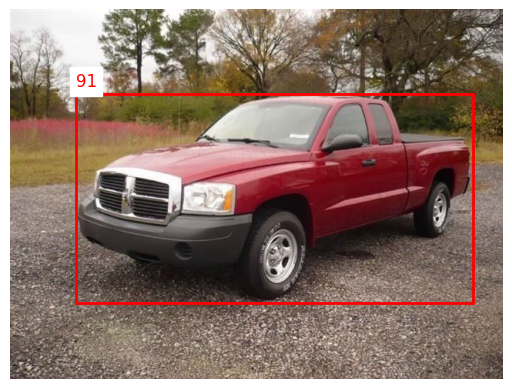

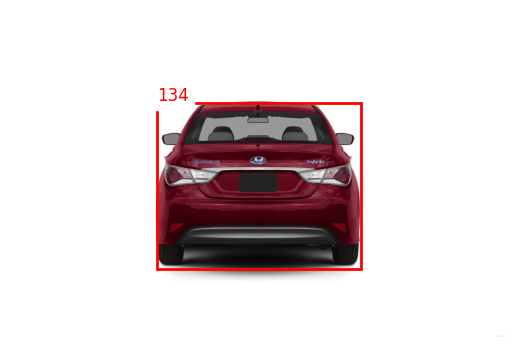

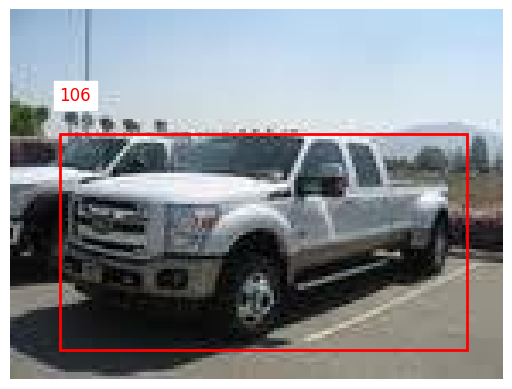

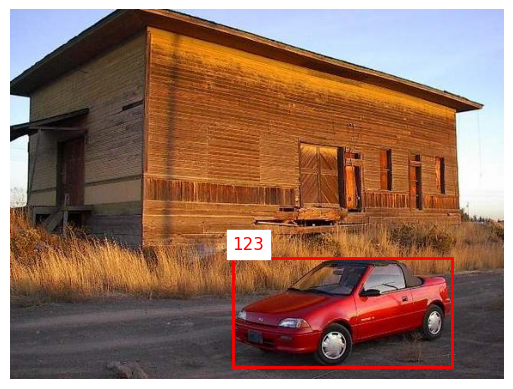

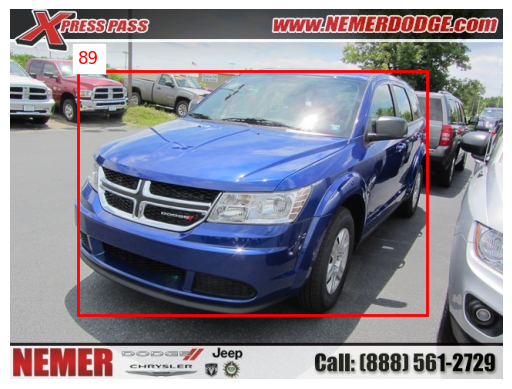

Displayed 5 training images with bounding boxes.
For Testing Images


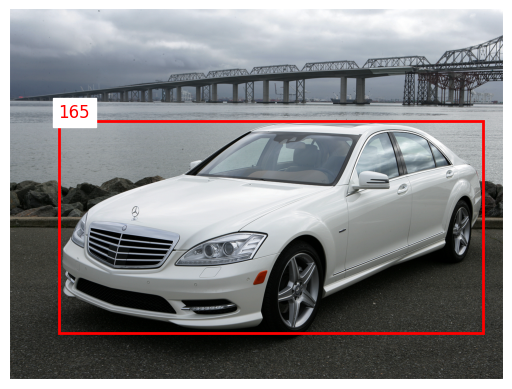

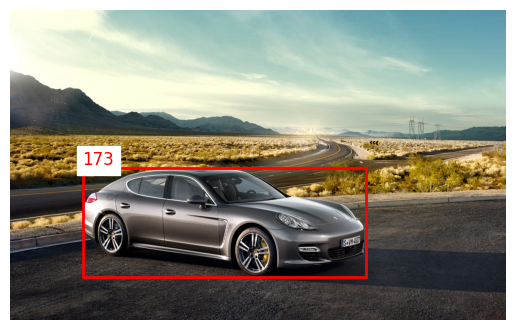

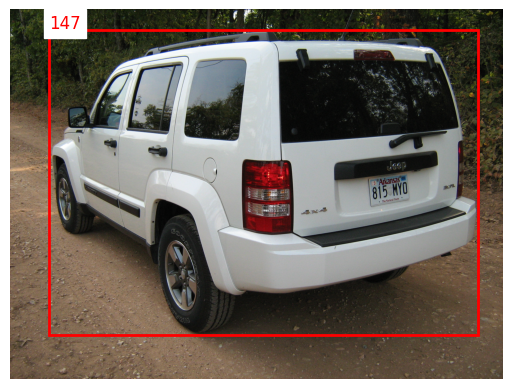

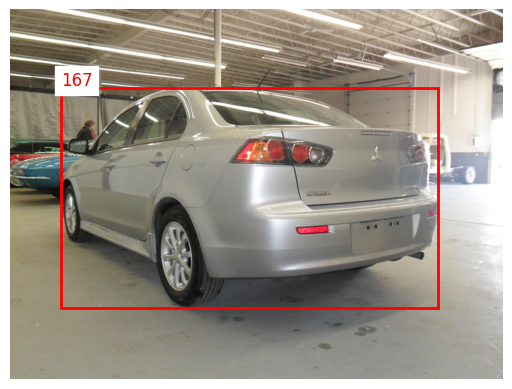

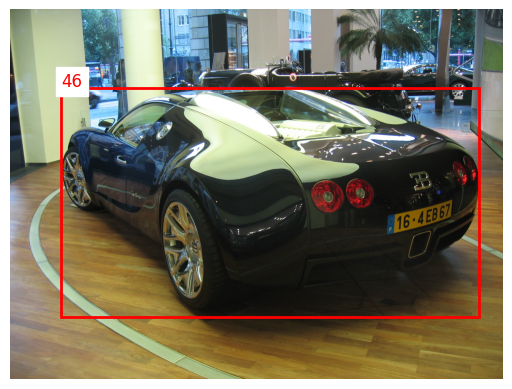

Displayed 5 test images with bounding boxes.


In [ ]:

# Display images with bounding boxes
def display_image_with_bbox(image_path, annotation):
    # Load image
    img = Image.open(image_path)

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding box
    x_min = row['Bounding Box coordinates_xmin']
    y_min = row['Bounding Box coordinates_ymin']
    x_max = row['Bounding Box coordinates_xmax']
    y_max = row['Bounding Box coordinates_ymax']
    image_class = row['Image class']
    bbox = annotation['bbox']
    rect = patches.Rectangle(
        (x_min, y_min),  # (x_min, y_min) -  (bbox[0], bbox[1])
        (x_max - x_min),   # width (x_max - x_min)  - bbox[2] - bbox[0]
        (y_max - y_min),   # height (y_max - y_min) -- bbox[3] - bbox[1]
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add class label
    plt.text(
        bbox[0], bbox[1] - 10,  # Position of the label
        annotation['image_class'],
        color='red',
        fontsize=12,
        backgroundcolor='white'
    )

    plt.axis('off')
    plt.show()


# for training images - Rewritten for displaying only five images
print("For Training Images") # Changed message to "Test Image"
displayed_image_count = 0  # Initialize a counter to track displayed images

image_paths_details_training=[]
images_paths_details_testing=[]

for index, row in train_image_annot_dir_file.iterrows():
    if displayed_image_count >= 5: # Check if we've already displayed two images
        break  # If yes, exit the loop

    image_name = str(row['Image Name']).strip()
    image_path = None # Initialize image_path to None


    for class_folder in train_class_folders:
        potential_image_path = os.path.join(class_folder, image_name)
        if os.path.exists(potential_image_path):
            image_path = potential_image_path
            image_paths_details_training.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path: # If image_path is found (not None)
        annotation = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class']
        }
        display_image_with_bbox(image_path, annotation)
        displayed_image_count += 1 # Increment the counter
    #else:
    #    print(f"Training Image not found: {image_name}")

print(f"Displayed {displayed_image_count} training images with bounding boxes.")
#*****************************************************************************************

# for test images - Rewritten for displaying only two images (or adjust as needed)
print("For Testing Images") # Changed message to "Test Image"
displayed_image_count_test = 0  # Initialize a counter to track displayed images

for index, row in test_image_annot_dir_file.iterrows():  # Use test_annotations_df DataFrame
    if displayed_image_count_test >= 5: # Check if we've already displayed two images (adjust number here if you want 5 or more)
        break  # If yes, exit the loop

    image_name_test = str(row['Image Name']).strip()
    image_path_test = None # Initialize image_path_test to None

    for class_folder in test_class_folders: # Use test_class_folders
        potential_image_path_test = os.path.join(class_folder, image_name_test)
        if os.path.exists(potential_image_path_test):
            image_path_test = potential_image_path_test # Assigned to image_path_test
            images_paths_details_testing.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path_test: # If image_path_test is found (not None)
        annotation_test = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class'] # Assuming 'Image class' column also exists in test_annotations_df (verify!)
        }
        display_image_with_bbox(image_path_test, annotation_test)  # Changed here
        displayed_image_count_test += 1 # Increment the counter
    #else:
    #    print(f"Test Image not found: {image_name_test}") # Changed message to "Test Image"

print(f"Displayed {displayed_image_count_test} test images with bounding boxes.") # Changed message to "test images"



# **Design, Train, and Test Basic CNN Models to Classify the Car**

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for CNN input.
    """
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None  # Or handle the missing image in a way that makes sense for your application

    image = cv2.imread(image_path)  # Load image

    # Check if image loading was successful
    if image is None:
        print(f"Warning: Failed to load image: {image_path}")
        return None  # Or handle the loading error as needed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Apply preprocessing to all images

df_testing['image'] = df_testing['Image_Path'].apply(preprocess_image)
df_training['image'] = df_training['Image_Path'].apply(preprocess_image)

# Check for and handle None values in the 'image' column
df_testing = df_testing.dropna(subset=['image'])  # Remove rows with None in 'image'
df_training = df_training.dropna(subset=['image'])  # Remove rows with None in 'image'

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df_testing['labels_encoded'] = label_encoder.fit_transform(df_testing['labels'])
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

# Convert labels to categorical (one-hot encoding)
df_testing['label_categorical'] = df_testing['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))
df_training['label_categorical'] = df_training['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))

In [ ]:
def custom_generator(df, batch_size, target_size):
    """
    Custom generator for images and labels.
    """
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image = preprocess_image(row['Image_Path'], target_size)
                label = row['label_categorical']
                images.append(image)
                labels.append(label)
            X = np.array(images)
            y = np.array(labels)
            yield X, y

# Create generators
batch_size = 32
train_generator = custom_generator(df_training, batch_size, target_size=(224, 224))
val_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))

In [ ]:
# Check training generator
X_batch, y_batch = next(train_generator)
print("Training batch shape:", X_batch.shape, y_batch.shape)

# Check validation generator
X_batch, y_batch = next(val_generator)
print("Validation batch shape:", X_batch.shape, y_batch.shape)

Training batch shape: (32, 224, 224, 3) (32, 196)
Validation batch shape: (32, 224, 224, 3) (32, 196)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense  # Import layers directly from keras.layers
from tensorflow.keras import layers, models # You may need this if you are using other keras components


# Example CNN model
model = Sequential([
#    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#    MaxPooling2D((2, 2)),
#    Flatten(),
#    Dense(128, activation='relu'),
#    Dense(len(test_class_folders), activation='softmax')
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Conv layer 1
    layers.MaxPooling2D((2, 2)),  # Pooling layer 1
    layers.Conv2D(64, (3, 3), activation='relu'),  # Conv layer 2
    layers.MaxPooling2D((2, 2)),  # Pooling layer 2
    layers.Conv2D(128, (3, 3), activation='relu'),  # Conv layer 3
    layers.MaxPooling2D((2, 2)),  # Pooling layer 3
    layers.Flatten(),  # Flatten the output
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(196, activation='softmax')  # Output layer (196 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(df_training) // batch_size,
    validation_data=val_generator,
    validation_steps=len(df_testing) // batch_size,
    epochs=10
)

test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.0193 - loss: 5.1905 - val_accuracy: 0.0000e+00 - val_loss: 5.3255
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.0241 - loss: 5.2036 - val_accuracy: 0.0000e+00 - val_loss: 5.3572
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.0322 - loss: 5.1697 - val_accuracy: 0.0000e+00 - val_loss: 5.3956
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 279ms/step - accuracy: 0.0301 - loss: 5.1253 - val_accuracy: 0.0000e+00 - val_loss: 5.4344
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 287ms/step - accuracy: 0.0281 - loss: 5.0943 - val_accuracy: 0.0000e+00 - val_loss: 5.4854
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 289ms/step - accuracy: 0.0269 - loss: 5.0567 - val_accuracy: 0.0000e+00 - val_loss: 5.7826
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 286ms/step - accuracy: 0.0000e+00 - loss: 5.0338 - val_accuracy: 0.0000e+00 - val_loss: 5.6438
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/s